- Do "better" hosts charge more?
- Do "better" hosts get more positive reviews
- How concentrated is the actual host market?

In [2]:
import pandas as pd
import numpy as np

import re

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/listings.csv.gz', compression='gzip')

In [4]:
with pd.option_context('display.max_columns',None):
    display(df.head())

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53344884,https://www.airbnb.com/rooms/53344884,20220921172238,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431412286,https://www.airbnb.com/users/show/431412286,Carlos Henrique,2021-11-11,NaN,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/f4bec...,https://a0.muscache.com/im/pictures/user/f4bec...,NaN,10.0,10.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.98299,-43.18904,Entire condo,Entire home/apt,6,NaN,4.5 baths,3.0,5.0,"[""Air conditioning"", ""Washer"", ""Security camer...","$3,500.00",3,365,3,3,365,365,3.0,365.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,10,8,2,0,NaN
1,7801456,https://www.airbnb.com/rooms/7801456,20220921172238,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,"Ipanema é considerado o berço do rio, cheio de...",https://a0.muscache.com/pictures/99276394/dc9c...,40650139,https://www.airbnb.com/users/show/40650139,Carlos Alberto,2015-08-05,"Rio de Janeiro, Brazil","22 anos, Brasileiro, Solteiro, residencia fixa...",a few days or more,13%,100%,f,https://a0.muscache.com/im/users/40650139/prof...,https://a0.muscache.com/im/users/40650139/prof...,Ipanema,6.0,6.0,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98723,-43.20452,Entire serviced apartment,Entire home/apt,4,NaN,2 baths,2.0,3.0,"[""Cable TV"", ""Air conditioning"", ""Fire extingu...","$5,000.00",2,900,2,2,900,900,2.0,900.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,5,5,0,0,NaN
2,14333905,https://www.airbnb.com/rooms/14333905,20220921172238,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,87749071,https://www.airbnb.com/users/show/87749071,Lindenberg,2016-08-03,"Rio de Janeiro, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/409ec...,https://a0.muscache.com/im/pictures/user/409ec...,NaN,1.0,1.0,"['email', 'phone']",t,f,NaN,Pavuna,NaN,-22.80869,-43.38642,Entire home,Entire home/apt,12,NaN,1 bath,2.0,4.0,"[""Cable TV"", ""Air conditioning"", ""Hair dryer"",...",$681.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
3,44708736,https://www.airbnb.com/rooms/44708736,20220921172238,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,A Marina da Glória fica no bairro do Flamengo ...,https://a0.muscache.com/pictures/210e9

# Sanity Checks

## Empty Values

In [5]:
col_na_proportion = df.isna().mean()

In [6]:
col_na_proportion[col_na_proportion > 0.1].round(3) # Arbitrary minimum NA boundary of 10% of rows

neighborhood_overview           0.473
host_location                   0.182
host_about                      0.515
host_response_time              0.133
host_response_rate              0.133
host_acceptance_rate            0.134
host_neighbourhood              0.407
neighbourhood                   0.473
neighbourhood_group_cleansed    1.000
bathrooms                       1.000
calendar_updated                1.000
first_review                    0.266
last_review                     0.266
review_scores_rating            0.266
review_scores_accuracy          0.274
review_scores_cleanliness       0.274
review_scores_checkin           0.274
review_scores_communication     0.274
review_scores_location          0.274
review_scores_value             0.274
license                         1.000
reviews_per_month               0.266
dtype: float64

- Some columns are complely empty
- About half of the listings don't have any description about the host
- Approx. 1 out of 4 listings don't have a review

- Bathrooms columns was actually replaced with bathrooms_text

In [7]:
full_na_cols = list(col_na_proportion[col_na_proportion == 1].index)

In [8]:
full_na_cols

['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license']

## Subsetting to relevant features

We are looking into the listings and trying to see what are the best findings given a set of their features

In [9]:
# Subsetting to columns that might be relevant for us to work with
# Ignoring relevant columns that are completely empty (ex: bathrooms)
subset_cols = ['id',
                'listing_url',
                'last_scraped',
                'source',
                'name',
                'description',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms_text',
                'bedrooms',
                'beds',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights',
                'number_of_reviews_ltm',
                'number_of_reviews_l30d',
                'review_scores_cleanliness',
                'review_scores_checkin', 
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value']

In [10]:
df_subset = df[subset_cols].copy() # Generating a copy to avoid object reference problems when creating new cols

In [11]:
df_subset.isna().mean()

id                             0.000000
listing_url                    0.000000
last_scraped                   0.000000
source                         0.000000
name                           0.000721
description                    0.031366
neighbourhood_cleansed         0.000000
property_type                  0.000000
room_type                      0.000000
accommodates                   0.000000
bathrooms_text                 0.001896
bedrooms                       0.049723
beds                           0.008951
amenities                      0.000000
price                          0.000000
minimum_nights                 0.000000
maximum_nights                 0.000000
number_of_reviews_ltm          0.000000
number_of_reviews_l30d         0.000000
review_scores_cleanliness      0.274179
review_scores_checkin          0.274179
review_scores_communication    0.274179
review_scores_location         0.274217
review_scores_value            0.274179
dtype: float64

In exception to the review columns, the subset does not have a lot of NaNs

## Subset - Type handling

In [12]:
df_subset.dtypes

id                               int64
listing_url                     object
last_scraped                    object
source                          object
name                            object
description                     object
neighbourhood_cleansed          object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms_text                  object
bedrooms                       float64
beds                           float64
amenities                       object
price                           object
minimum_nights                   int64
maximum_nights                   int64
number_of_reviews_ltm            int64
number_of_reviews_l30d           int64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
dtype: object

### Dates

In [13]:
# Handling scraped date
df_subset['last_scraped'] = pd.to_datetime(df_subset['last_scraped'], yearfirst=True)

In [14]:
# Check if dataset contains old entries - They might not be relevant
df_subset['last_scraped'].value_counts()

2022-09-22    20849
2022-09-21     5462
2022-09-23       54
2022-10-02        1
Name: last_scraped, dtype: int64

### Prices

In [15]:
# Price

# Do all prices start with '$'?
print(df_subset['price'].shape[0] == df_subset['price'].str.startswith('$').sum())

True


In [16]:
df_subset['price'] = df_subset['price'].str[1:]

df_subset['price'] = df_subset['price'].str.replace(',','', regex=True)

df_subset['price'] = df_subset['price'].astype(float)

### Amenities

In [17]:
df_subset['amenities'].head()

0    ["Air conditioning", "Washer", "Security camer...
1    ["Cable TV", "Air conditioning", "Fire extingu...
2    ["Cable TV", "Air conditioning", "Hair dryer",...
3    ["Single level home", "Wifi \u2013 30 Mbps", "...
4    ["Air conditioning", "First aid kit", "Iron", ...
Name: amenities, dtype: object

In [18]:
# Are amenities strings?
(df_subset['amenities'].apply(type) == str).all()

True

Amenities are actually strings instead of lists. This needs fixing.\
Also, since it is a whole string, the whitespaces before the quotes will stay there. They need to be fixed too.\
To fix the whitespaces I will be using a function, but it could be done via RegEx as well.\
Also, some not parsed unidecode characters get into the dataset. They will be removed since they probably won't be word characters

In [19]:
def strip_tokens(token_list):

    return [token.strip() for token in token_list]

def replace_unidecode(token_list):

    ''' Replaces non-parsed unidecode chars with single Whitespace.
        If simply replaced by empty strings, will generate a double whitespace
        '''

    return [re.sub(r'\s+', ' ', re.sub(r'\\u\d+','', token)) for token in token_list]

In [20]:
# The Brackets and quotes will break a simple split function. They need to be treated beforehand.
df_subset['amenities'] = df_subset['amenities'].str.replace('\[|\]|\"','', regex = True)\
                                                .str.split(',')\
                                                .apply(strip_tokens)\
                                                .apply(replace_unidecode)

In [21]:
display(df_subset['amenities'].head())

display(df_subset['amenities'][0]) # Example for specific fixes

0    [Air conditioning, Washer, Security cameras on...
1    [Cable TV, Air conditioning, Fire extinguisher...
2    [Cable TV, Air conditioning, Hair dryer, Iron,...
3    [Single level home, Wifi 30 Mbps, Dedicated wo...
4    [Air conditioning, First aid kit, Iron, Essent...
Name: amenities, dtype: object

['Air conditioning',
 'Washer',
 'Security cameras on property',
 'Wifi',
 'Long term stays allowed',
 'Kitchen',
 'TV']

## Bathrooms

In [50]:
df_subset.bathrooms_text

0            4.5 baths
1              2 baths
2               1 bath
3              2 baths
4               1 bath
             ...      
26361    1 shared bath
26362           1 bath
26363           1 bath
26364           1 bath
26365           1 bath
Name: bathrooms_text, Length: 26366, dtype: object

In [60]:
print('Entries that contain "bath":',df_subset[df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)].shape[0])

print('Total Entries:',df_subset.shape[0])

Entries that contain "bath": 26316
Total Entries: 26366


There are 50 entries that don't contain the any word with 'bath' in it

In [64]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)]['bathrooms_text'].isna().sum()

50

The different entries are empty are because they are NaN values

In [67]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)][['name','description']].sample(10, random_state=123)

,name,description
479,Praia da Macumba Recreio,"<b>The space</b><br />Apartameno pequeno,1 Qto..."
603,Cozy room @ Copacabana - Posto 06,<b>The space</b><br />Excellent apartment near...
2056,Maracana - apartamento a 200 metros,Excelente apartamento a 200 metros do MARACANÃ...
19656,Mansão INCRÍVEL no meio da natureza para EVENTOS,NaN
661,ótimo Quarto em Santa Teresa - RJ,<b>The space</b><br />Casa ampla em Santa Tere...
89,Apartamento Moderno e confortavel,"Seja bem vindo a esse apartamento moderno, con..."
14651,Américas Copacabana Hotel,NaN
600,Vinicius,"tarifa baixa temporada, mínimo 5 noites<br /><..."
869,Ipanema 602,"<b>The space</b><br />linen not included, on r..."
348,BAND NEW APT COPACABANA,<b>The space</b><br />APT JUST RENOVATED! ALL ...


From the descriptions, it doesn't look like these are listings that don't have bathrooms. Imputing with some value might be more realistic.\
Also, there are not many listings without the number of bathrooms. It shouldn't impact us much

After some inspections there are some key tokens that will be removed, for simplicity:

- Bath(s)
- Shared
- Private

In [71]:
df_subset['bathrooms_text'].str.contains('shared').sum()

3156

In [87]:
df_subset['bathrooms_text'].str.contains('private').sum()

1727

In [91]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'bath[s]?|shared|private','',case = False,regex = True)\
                                                            .str.strip()

In [ ]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array(['half-', 'Half-'], dtype=object)

In [93]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'half-','0.5',case = False,regex = True)\
                                                            .str.strip()

In [94]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array([], dtype=object)

In [ ]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array(['half-', 'Half-'], dtype=object)

# Analysis

## Amenities analysis

- What are the most usual Amenities?
    - Relative to total Amenities occurance
    - Relative to total number of listings
- What are the Amenities that might have the biggest price differences

Let's create a quick pseudo-corpus for our data and see if we can keep only some key amenities or come up with other fixes.\
I'm specially interested in the Wifi amenity that contains internet speed. Wifi available or not should be counted regardless of speed. This, of course, excluding specific cases such as well-equipped, remote-work ready AirBnBs\
It's a pseudo corpus because we are keeping duplicated values. This will come in handy if when choosing to keep key amenities

In [22]:
amenities_corpus = df_subset['amenities'].explode()

In [23]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  3260


In [24]:
# Looking specifically into wifi
len(amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique())

401

In [25]:
amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique()

array(['Wifi', 'Wifi 30 Mbps', 'Pocket wifi', 'Wifi 28 Mbps',
       'Fast wifi 101 Mbps', 'Fast wifi 663 Mbps', 'Fast wifi 55 Mbps',
       'Fast wifi 157 Mbps', 'Fast wifi 66 Mbps', 'Fast wifi 542 Mbps',
       'Fast wifi 413 Mbps', 'Fast wifi 136 Mbps', 'Fast wifi 52 Mbps',
       'Fast wifi 543 Mbps', 'Wifi 18 Mbps', 'Fast wifi 286 Mbps',
       'Fast wifi 155 Mbps', 'Fast wifi 159 Mbps', 'Wifi 23 Mbps',
       'Fast wifi 94 Mbps', 'Wifi 4 Mbps', 'Wifi 6 Mbps',
       'Fast wifi 409 Mbps', 'Fast wifi 248 Mbps', 'Fast wifi 463 Mbps',
       'Fast wifi 60 Mbps', 'Fast wifi 82 Mbps', 'Fast wifi 235 Mbps',
       'Fast wifi 124 Mbps', 'Wifi 42 Mbps', 'Fast wifi 341 Mbps',
       'Fast wifi 340 Mbps', 'Fast wifi 238 Mbps', 'Fast wifi 259 Mbps',
       'Moderno apartamento com WIFI conditioner', 'Fast wifi 112 Mbps',
       'Wifi 34 Mbps', 'Fast wifi 194 Mbps', 'Fast wifi 334 Mbps',
       'Wifi 41 Mbps', 'Fast wifi 119 Mbps', 'Fast wifi 224 Mbps',
       'Fast wifi 163 Mbps', 'Fast wifi

There are a lot of possible entries for wifi, we'll replace them all for simplicity.\
Will do it in two categories: Fast and Regular Wifi

In [26]:
reg_wifi_pat = r'(?<!Fast\s)wifi'

fast_wifi_pat = r'(?<=Fast\s)wifi'

In [27]:
reg_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(reg_wifi_pat, case = False)].unique())

fast_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(fast_wifi_pat, case = False)].unique())

In [28]:
amenities_corpus = amenities_corpus.str.replace(reg_wifi_repl_str,'Wifi', regex = True)\
                                    .str.replace(fast_wifi_repl_str,'Fast Wifi', regex = True)

In [29]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  2910


In [30]:
# Início do Pareto - Selecionar apenas amenities relevantes e mantelas como features
amenities_corpus.value_counts()

Wifi                                                          23836
Kitchen                                                       23760
Long term stays allowed                                       23165
Essentials                                                    20214
Hangers                                                       17093
                                                              ...  
Alexa Amazon sound system                                         1
Nivea hidratante body soap                                        1
Lux Ledquido body soap                                            1
Ne3o e9 um foge3o e9 um fogareiro ele9trico electric stove        1
c0 de9finir shampoo                                               1
Name: amenities, Length: 2910, dtype: int64

In [37]:
amenities_pareto = amenities_corpus.value_counts().to_frame()

In [39]:
amenities_pareto.rename(columns = {'amenities':'count'}, inplace = True)

In [43]:
amenities_pareto['proportion'] = amenities_pareto['count'] / amenities_pareto['count'].sum()

In [48]:
amenities_pareto['cum_proportion'] = amenities_pareto['proportion'].cumsum()

In [49]:
amenities_pareto

,count,proportion,cum_proportion
Wifi,23836,0.040812,0.040812
Kitchen,23760,0.040682,0.081493
Long term stays allowed,23165,0.039663,0.121156
Essentials,20214,0.034610,0.155767
Hangers,17093,0.029266,0.185033
...,...,...,...
Alexa Amazon sound system,1,0.000002,0.999993
Nivea hidratante body soap,1,0.000002,0.999995
Lux Ledquido body soap,1,0.000002,0.999997
Ne3o e9 um foge3o e9 um fogareiro ele9trico electric stove,1,0.000002,0.999998


In [32]:
df.shape[0]

(26366, 75)

<AxesSubplot:>

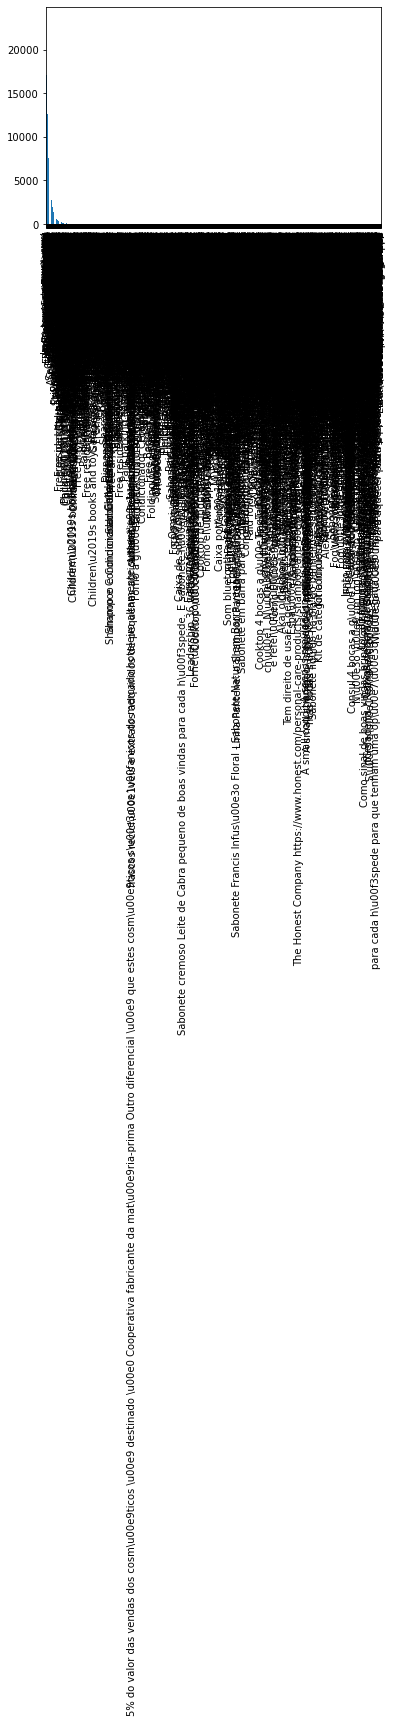

In [148]:
amenities_corpus.value_counts()

The type is correct. But it looks like some tokens have whitespaces

In [ ]:
df_subset['ameni']

In [86]:
df_subset['amenities'].str[0]

0        [
1        [
2        [
3        [
4        [
        ..
26361    [
26362    [
26363    [
26364    [
26365    [
Name: amenities, Length: 26366, dtype: object

In [79]:
df_subset['amenities']

0        ["Air conditioning", "Washer", "Security camer...
1        ["Cable TV", "Air conditioning", "Fire extingu...
2        ["Cable TV", "Air conditioning", "Hair dryer",...
3        ["Single level home", "Wifi \u2013 30 Mbps", "...
4        ["Air conditioning", "First aid kit", "Iron", ...
                               ...                        
26361    ["Air conditioning", "Iron", "Microwave", "Din...
26362    ["Air conditioning", "Hangers", "Dedicated wor...
26363    ["Air conditioning", "Fire extinguisher", "Wif...
26364    ["Stainless steel oven", "Dedicated workspace"...
26365    ["Dryer", "Free street parking", "Iron", "Esse...
Name: amenities, Length: 26366, dtype: object